## IMPORTANTO BIBLIOTECAS

In [3]:
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.preprocessing import image
from tensorflow import keras

import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import os

## PARÂMETROS

In [15]:
percentege_test_size = 0.2
undersampling_size = -1 # -1 para não fazer undersampling

# fig preprocessing
largura = 100
altura = 100
modo_de_cor = 'rgb' # rgb, grayscale, rgba
# fig preprocessing

# diretorio = '../dados classificacao imagens/star-wars/'
# diretorio = '../dados classificacao imagens/animais-kaggle/'
# diretorio = '../dados classificacao imagens/dataset-documentos-full/'
diretorio = './data/'

### CARREGANDO DATASET

In [16]:
targets = [x[0].replace(diretorio,'') for x in os.walk(diretorio)]

print(targets)
targets = targets[1:len(targets)] # exclui o primeiro da lista pq é o próprio diretório

print(targets)

dados = []

class_to_int = {}

k = 0

for classe in targets:
    imagens = os.listdir(diretorio+classe)
    i = 0
    class_to_int[classe] = k
    k+=1
    for img in imagens:
        i+=1
        
        if (not '.txt' in img) and (not 'segmentation' in img) and (not 'desktop.ini' in img):
            dados.append([diretorio+classe+'/'+img,class_to_int[classe]])
        
        if i == undersampling_size and undersampling_size != -1:
            break

dados = np.array(dados)

np.random.shuffle(dados)
            
df_dados = pd.DataFrame(dados,columns=['image','target'])

df_dados['target'] = df_dados['target'].astype('int64', copy=False)

df_dados

['', 'non-vehicles', 'vehicles']
['non-vehicles', 'vehicles']


,image,target
0,./data/non-vehicles/image830.png,0
1,./data/vehicles/middle (189).png,1
2,./data/vehicles/4409.png,1
3,./data/vehicles/2524.png,1
4,./data/non-vehicles/extra3510.png,0
...,...,...
17755,./data/non-vehicles/extra983.png,0
17756,./data/vehicles/4032.png,1
17757,./data/non-vehicles/extra4903.png,0
17758,./data/vehicles/5169.png,1


In [17]:
df_dados['target'].value_counts()

0    8968
1    8792
Name: target, dtype: int64

## PREPARANDO DADOS

In [45]:
def embedding(img_path,largura,altura,modo_de_cor):
    img = image.load_img(img_path, target_size=(largura, altura),color_mode= modo_de_cor)
    embed = image.img_to_array(img)

    return embed

In [46]:
y_full = df_dados['target'].array.to_numpy()

X_full  = []
for x in dados:
    X_full.append(embedding(x[0],largura,altura,modo_de_cor))

X_full = np.array(X_full)


In [47]:
model_test_size = int(len(y_full) * percentege_test_size)

X_test, X_train = X_full[:model_test_size] / 255.0, X_full[model_test_size:] / 255.0
y_test, y_train = y_full[:model_test_size], y_full[model_test_size:]

## TREINANDO E VALIDANDO O MODELO

In [60]:
shape_entrada = (largura,altura,1)

if(modo_de_cor == 'rgb'):
    shape_entrada = (largura,altura,3)

if(modo_de_cor == 'rgba'):
    shape_entrada = (largura,altura,4)

print(shape_entrada)

model = keras.models.Sequential([

########## MLP  #acc = 98.95 , params 1.5.M [0.09629715979099274, 0.9684684872627258] epochs = 53
#keras.layers.Flatten(input_shape=shape_entrada),
## keras.layers.Dense(3000, activation="relu"),
## keras.layers.Dense(1000, activation="relu"),
#keras.layers.Dense(50, activation="relu"),
#keras.layers.Dense(50, activation="relu"),

########## LSTM
 #keras.layers.LSTM(784, activation='relu', input_shape=shape_entrada),

########## Stacked LSTM
# keras.layers.LSTM(784, activation='relu', return_sequences=True, input_shape=shape_entrada),
# keras.layers.LSTM(250, activation='relu', return_sequences=True),
# keras.layers.LSTM(90, activation='relu', return_sequences=True),
# keras.layers.LSTM(30, activation='relu'),

########## Bidirectional LSTM
#keras.layers.Bidirectional(keras.layers.LSTM(100, activation='relu'), input_shape=shape_entrada),

########## Conv #20 min acc = 99.99, params 138k [0.004255861043930054, 0.9983108043670654]

keras.layers.InputLayer(input_shape=shape_entrada),
keras.layers.Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='same'),
keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),
keras.layers.Conv2D(50, (5, 5), activation='relu', strides=(2, 2), padding='same'),
keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),
keras.layers.BatchNormalization(),
keras.layers.Conv2D(70, (3, 3), activation='relu', strides=(2, 2), padding='same'),
keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
keras.layers.BatchNormalization(),
keras.layers.Flatten(),
keras.layers.Dense(units=100, activation='relu'),
keras.layers.Dense(units=100, activation='relu'),
keras.layers.Dropout(0.25),

    
keras.layers.Dense(len(np.unique(y_train)), activation="softmax")
])

(100, 100, 3)


In [61]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 100, 100, 25)      1900      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 50, 50, 25)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 25, 25, 50)        31300     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 13, 13, 50)       0         
 g2D)                                                            
                                                                 
 batch_normalization_6 (Batc  (None, 13, 13, 50)       200       
 hNormalization)                                                 
                                                     

In [62]:
model.compile(loss="sparse_categorical_crossentropy",
optimizer="adam",
metrics=["accuracy"])

In [63]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='max')]

callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, verbose=0, restore_best_weights=True))


history = model.fit(X_train, y_train, epochs=500,
                    validation_split=0.05,
                    callbacks=callbacks
                   )

Epoch 1/500
422/422 [==============================] - 28s 65ms/step - loss: 0.1177 - accuracy: 0.9555 - val_loss: 0.1969 - val_accuracy: 0.9339 - lr: 0.0010
Epoch 2/500
422/422 [==============================] - 28s 67ms/step - loss: 0.0428 - accuracy: 0.9843 - val_loss: 0.1918 - val_accuracy: 0.9226 - lr: 0.0010
Epoch 3/500
422/422 [==============================] - 28s 66ms/step - loss: 0.0243 - accuracy: 0.9913 - val_loss: 0.3026 - val_accuracy: 0.9044 - lr: 0.0010
Epoch 4/500
422/422 [==============================] - 28s 66ms/step - loss: 0.0255 - accuracy: 0.9912 - val_loss: 0.0698 - val_accuracy: 0.9817 - lr: 0.0010
Epoch 5/500
422/422 [==============================] - 28s 66ms/step - loss: 0.0185 - accuracy: 0.9934 - val_loss: 0.1131 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 6/500
422/422 [==============================] - 28s 66ms/step - loss: 0.0147 - accuracy: 0.9955 - val_loss: 0.0848 - val_accuracy: 0.9691 - lr: 0.0010
Epoch 7/500
422/422 [==============================]

## VALIDANDO DE FORMA MAIS ELABORADA

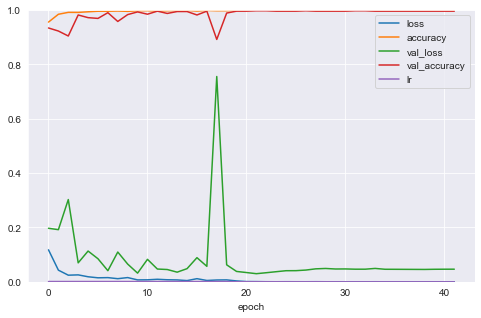

In [64]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.xlabel('epoch')
plt.show()

In [65]:
model.evaluate(X_test, y_test)

111/111 [==============================] - 2s 14ms/step - loss: 0.0043 - accuracy: 0.9983


[0.004255861043930054, 0.9983108043670654]

## VISUALIZANDO A MATRIZ DE CONFUSÃO

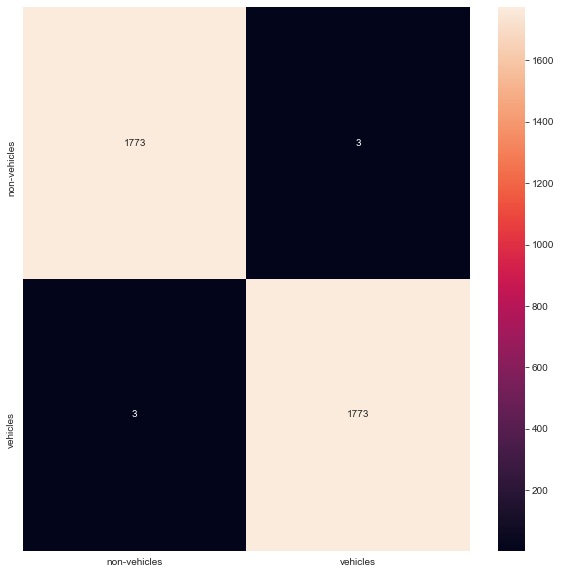

In [69]:
cm = confusion_matrix(y_test,np.argmax(model.predict(X_test), axis=-1))


cm_df = pd.DataFrame(cm,columns=class_to_int)


fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm_df, annot=True, fmt='d',
            xticklabels=class_to_int, yticklabels=class_to_int)

plt.show()